## Pneumonia Identification using Chest XRays

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import numpy as np
import cv2
import pickle
# from tqdm import tqdm

In [2]:
# DATA_DIR = "/home/aneeshashmi/Desktop/Main/py/tf/Chest/ChestXRays/train"
DATA_DIR = "/home/aneeshashmi/Desktop/Main/py/tf/Chest/ChestXRays/train1"
CATEGORIES = ["NORMAL", "PNEUMONIA"]
IMG_SIZE_X = 400
IMG_SIZE_Y = 400

In [3]:
def show_img(image):
    plt.imshow(image, cmap = plt.cm.gray)
    print("size: ", image.shape)

## Exploring the data? 

/home/aneeshashmi/Desktop/Main/py/tf/Chest/ChestXRays/train1/NORMAL
size:  (1704, 1828)


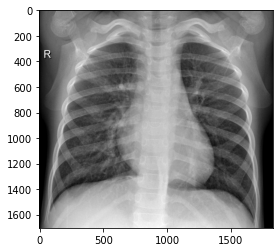

In [19]:
# loading an image
dir_addr = os.path.join(DATA_DIR, CATEGORIES[0])
imlst = os.listdir(dir_addr)
print(dir_addr)

# images are RGB
im = cv2.imread(os.path.join(dir_addr, imlst[0])
               ,cv2.IMREAD_GRAYSCALE # comment this line to load defualt color (RGB) images
               )
show_img(im)

size:  (400, 400)


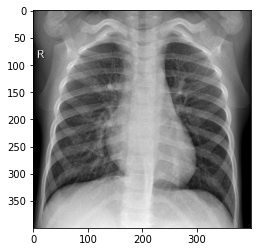

In [20]:
im_resized = cv2.resize(im, (IMG_SIZE_X, IMG_SIZE_Y))
show_img(im_resized)

### Load dataset
#### Try pickle or direct load and then save pickle

In [4]:
def pickle_it(filename,payload):
  with open(f'/home/aneeshashmi/Desktop/Main/py/tf/Chest/ChestXRays/{filename}', 'wb') as pickle_out:
    pickle.dump(payload, pickle_out)
  print("pickle dump successful")

def unpickle_it(filename):
  with open(f'/home/aneeshashmi/Desktop/Main/py/tf/Chest/ChestXRays/{filename}', 'rb') as pickle_in:
    unpickled = pickle.load(pickle_in)
  return unpickled

In [6]:
def load_dataset_from_device(data_dir, pickefilename):
    dataset = []
    for (i, category) in enumerate(CATEGORIES):
        print(f'loading {category}')
        path = os.path.join(data_dir, category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (IMG_SIZE_X, IMG_SIZE_Y))
                img_array = img_array/255 # normalize data
                dataset.append((img_array, CATEGORIES.index(category)))                 
            except Exception as e:
               pass
#     save data for later use
    # pickle.dump(dataset, open( pickefilename, "wb" ))
    pickle_it(pickefilename, dataset)
    return dataset

# try pickle and then load data
def load_dataset():
    try:
#         dataset = load_dataset_from_device(DATA_DIR, "xrays_dataset.p")
        dataset  = unpickle_it("xrays_dataset.p")
        print("loading model from pickle...")
    except Exception as e:
        dataset = load_dataset_from_device(DATA_DIR, "xrays_dataset.p")
    return dataset

dataset = load_dataset()


# dataset = load_dataset_from_device(DATA_DIR, "xrays_dataset.pkl")

loading NORMAL
loading PNEUMONIA
pickle dump successful


### Shuffle loaded data and make image and label arrays
Training data = 80%

Cross validation data = 20%

In [7]:
import random
import math

def shuffle_dataset(dataset):
    random.shuffle(dataset)
    
    X = []
    y = []
    [[X.append(img), y.append(label)] for (img, label) in dataset]

    # cross-validation dataset     
    # 20% data
    X_cv = X[math.ceil(len(X)*0.8):]
    y_cv = y[math.ceil(len(y)*0.8):]
    X_cv = np.array(X_cv).reshape(-1, IMG_SIZE_X, IMG_SIZE_Y, 1)
    y_cv = np.array(y_cv).reshape(-1,1)
    
    # training dataset     
    # 80% data
    X = X[:math.ceil(len(X)*0.8)]
    y = y[:math.ceil(len(y)*0.8)]
    X = np.array(X).reshape(-1, IMG_SIZE_X, IMG_SIZE_Y, 1)
    y = np.array(y).reshape(-1,1)

    return (X, y, X_cv, y_cv)


(X,y, X_cv, y_cv) = shuffle_dataset(dataset)

In [8]:
X_cv[0]

array([[[0.05882353],
        [0.0627451 ],
        [0.0745098 ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.05882353],
        [0.0627451 ],
        [0.0745098 ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.0627451 ],
        [0.0627451 ],
        [0.0745098 ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

## Model

In [9]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32,kernel_size=(4,4), activation = "relu", input_shape=(IMG_SIZE_X,IMG_SIZE_Y,1)) ,
        tf.keras.layers.MaxPooling2D(pool_size = (2,2)), # reduce spatial resolution

        tf.keras.layers.Conv2D(filters=64,kernel_size=(4,4), activation = "relu") ,
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 

        tf.keras.layers.Flatten(), # size will be selected aumatically
        tf.keras.layers.Dense(64, activation = "relu"),

        # softmax gives prob dist sum = 1 and typically used for multivariate classification
        tf.keras.layers.Dense(2, activation = "softmax"), # classifying two categories only
])

model.compile(
    optimizer="adam",
#               optimizer='SGD',
#               optimizer='rmsprop',
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

### Let's train the model

In [ ]:
model.fit(X,y, epochs = 1)
model.save("xrays_model")

### Testing model

In [ ]:

test_data = load_dataset_from_device("/home/aneeshashmi/Desktop/Main/py/tf/Chest/ChestXRays/test", "xrays_testdataset.p")

In [ ]:
(X_test,y_test) = shuffle_dataset(test_data)

In [ ]:
model.evaluate(X_test,y_test)
# model.weights

 6/20 [========>.....................] - ETA: 40s - loss: 1.3159 - accuracy: 0.3333

In [ ]:
model.fit(X,y, epochs = 1)
model.save("xrays_model")